### Playground and Tutorials for Julia Modeling Toolkit

In [1]:
using ModelingToolkit
using ModelingToolkit: t_nounits as t, D_nounits as D
using OrdinaryDiffEq
using Plots

### Scenario 1:
Quick facts:
- Two patches, 1 connecting corridor. 
- Initial conditions (total vehicle population = 1):
    - Patch 1: 0.9
    - Patch 2: 0
    - Corridor 1 heading to Patch 1: 0.05
    - Corridor 1 heading to Patch 2: 0.05
- Everyone from Patch 1 wants to go to Patch 2 (dp1 = 1.0). No one from Patch 2 wants to go to Patch 1 (dp2 = 0.0). 
- Patch populations have equivalent tolerance for congestion (alpha_1 = alpha_2 = 1.0). 
- Corridor 1 has a jam capacity of 0.1 (10% of total vehicle population), therefore beta_c1 = 10.

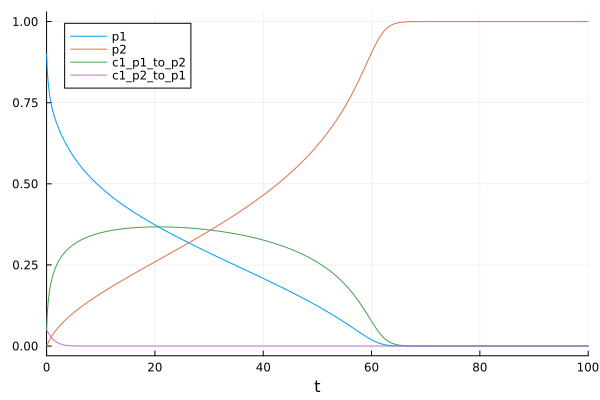

In [3]:
@mtkmodel FOL begin
    @parameters begin
        d_p1 = 1.0
        d_p2 = 0.0
        alpha_1 = 1.0 # parameters and their values
        alpha_2 = 1.0
        beta_c1 = 10
    end
    @variables begin
        p1(t) = 0.9 # dependent variables and their initial conditions
        p2(t) = 0.0
        c1_p1_to_p2(t) = 0.05
        c1_p2_to_p1(t) = 0.05
        F_c1_to_p1(t)
        F_c1_to_p2(t)
        F_p1_to_c1(t)
        F_p2_to_c1(t)
    end
    @equations begin
        # Leaving functions
        F_p1_to_c1 ~ d_p1 * exp(- (alpha_1 * beta_c1) * c1_p1_to_p2) * p1
        F_p2_to_c1 ~ d_p2 * exp(- (alpha_2 * beta_c1) * c1_p2_to_p1) * p2

        # Arriving functions
        F_c1_to_p1 ~ exp(-beta_c1 * c1_p2_to_p1) * c1_p2_to_p1
        F_c1_to_p2 ~ exp(-beta_c1 * c1_p1_to_p2) * c1_p1_to_p2

        # Main equations
        D(p1) ~ F_c1_to_p1 - F_p1_to_c1
        D(p2) ~ F_c1_to_p2 - F_p2_to_c1
        D(c1_p1_to_p2) ~ F_p1_to_c1 - F_c1_to_p2
        D(c1_p2_to_p1) ~ F_p2_to_c1 - F_c1_to_p1
    end
end

@mtkbuild fol = FOL()
prob = ODEProblem(fol, [], (0.0, 100.0), [])
plot(solve(prob)) # How to quickly add text boxes for parameters?

### Scenario 2
- Now, some people from Patch 2 want to go to Patch 1 (20% of the population of P2)

**What we see**
- Now, the population in Patch 2 stagnates around 0.04. P1 approaches equilibrium with C_p1_to_p2. This means there are almost always people on the highway going from Patch 1 to Patch 2. But this does not lead to an increase in the population of P2, or even perturbations of that population. So what is happening? People are stuck on the road forever? Well, P2 does have a non-zero population. So maybe there is just constant exchange? Still, this makes me question how we can interpret travel times from this graph. I think we shouldn't use the width of the curve as a representative of ``rush hour'' as we have been. Probably we should look directly at the fluxes (for each time step?) if we want to get a sense of the rate of exiting.
- But also, this population in Corridor 1 is way higher than the jam capacity. So that implies everybody is barely moving... (should probably plot the jam capacity as a horizontal line).

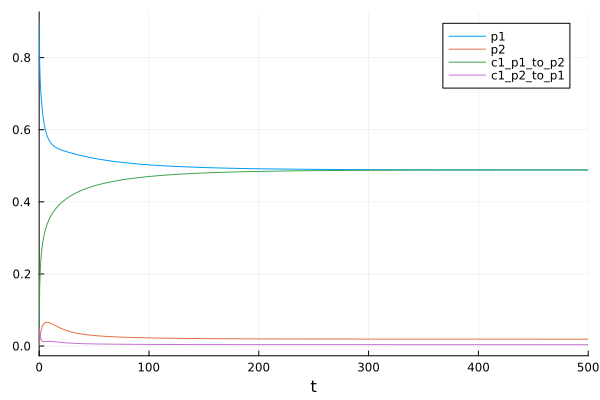

In [9]:
@mtkbuild fol_different_values = FOL(; d_p2 = 0.2)
prob = ODEProblem(fol_different_values, [], (0.0, 500.0), [])
sol = solve(prob)
plot(sol)

In [11]:
sol[fol_different_values.p1]

47-element Vector{Float64}:
 0.9
 0.8809669447621858
 0.864774238023963
 0.8440624485822363
 0.8233217586312132
 0.8003996120216758
 0.776931769044237
 0.7523846995306525
 0.7273116128879467
 0.7017705856647576
 0.678145023062603
 0.6570167403932838
 0.637910299910969
 ⋮
 0.5056667106364091
 0.5023181051037637
 0.4995888412932725
 0.49682029282481754
 0.49459529378986644
 0.4925791573580359
 0.49107452394335044
 0.4899090007501409
 0.48917453498748603
 0.48874220671496654
 0.4885531357755564
 0.4885327683087448

## Experiments to help figure out how to use vector-valued variables

In [12]:
using ModelingToolkit, OrdinaryDiffEq

@parameters t
@variables (z(t))[1:3] #z[1:3](t)
#@derivatives D'~t
eqs = [D(z[i]) ~ -z[i] for i in 1:3]
@named sys = ODESystem(eqs, t)
fol = structural_simplify(sys)
initial_conditions = [i for i in 1:3]
prob = ODEProblem(fol, initial_conditions, (0.0, 10.0), [])
using OrdinaryDiffEq
sol = solve(prob)

using Plots
plot(sol)

LoadError: cannot assign a value to imported variable Main.t

## Try in the typical MTK environment

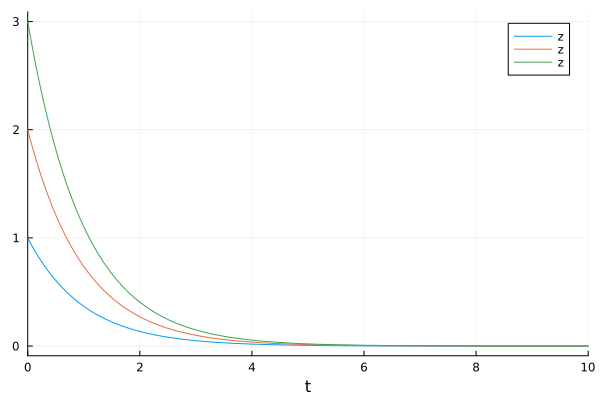

In [14]:
using ModelingToolkit, OrdinaryDiffEq

@mtkmodel FOL begin
    @parameters begin
        d_p1 = 1.0
    end
    @variables begin
        (z(t))[1:3]
    end
    @equations begin
        # Main equations
        [D(z[i]) ~ -z[i] for i in 1:3]
    end
end

@mtkbuild fol = FOL()
initial_conditions = [i for i in 1:3]
prob = ODEProblem(fol, initial_conditions, (0.0, 10.0), [])
sol = solve(prob)
plot(sol) # How to quickly add text boxes for parameters?

using Plots
plot(sol)